<a href="https://colab.research.google.com/github/FatemaShawki/Flood-Susceptibility-Forecasting-using-Machine-Learning/blob/main/Flood_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install plotly_express

In [5]:
!pip install jcopml

In [54]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import joblib
import plotly.express as px
from plotly.express import scatter_geo
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import grid_search_params as gsp


# Data Preprocessing and visualization

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('/content/drive/MyDrive/earthquake_data.csv')
print(df.columns.tolist())
df[0:2].T

['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']


,0,1
title,"M 7.0 - 18 km SW of Malango, Solomon Islands","M 6.9 - 204 km SW of Bengkulu, Indonesia"
magnitude,7.0,6.9
date_time,22-11-2022 02:03,18-11-2022 13:37
cdi,8,4
mmi,7,4
alert,green,green
tsunami,1,0
sig,768,735
net,us,us
nst,117,99


In [10]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')
df['year']= df['date_time'].apply(lambda x:x.year)

In [11]:
print(df['year'].min(),df['year'].max())
print(df['magnitude'].min(),df['magnitude'].max())
print(df['depth'].min(),df['depth'].max())

2001 2022
6.5 9.1
2.7 670.81


In [12]:
scatter_geo(data_frame=df, lat="latitude",lon="longitude",scope="world",
            color="magnitude",hover_name="magnitude",size='magnitude')

In [14]:
# Read flood data
df = pd.read_csv("/content/drive/MyDrive/earthquake_data.csv")

In [15]:
# Information about the data, including data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      782 non-null    object 
 1   magnitude  782 non-null    float64
 2   date_time  782 non-null    object 
 3   cdi        782 non-null    int64  
 4   mmi        782 non-null    int64  
 5   alert      415 non-null    object 
 6   tsunami    782 non-null    int64  
 7   sig        782 non-null    int64  
 8   net        782 non-null    object 
 9   nst        782 non-null    int64  
 10  dmin       782 non-null    float64
 11  gap        782 non-null    float64
 12  magType    782 non-null    object 
 13  depth      782 non-null    float64
 14  latitude   782 non-null    float64
 15  longitude  782 non-null    float64
 16  location   777 non-null    object 
 17  continent  206 non-null    object 
 18  country    484 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 1

In [16]:
df.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,0.388747,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199
std,0.445514,3.169939,1.462724,0.487778,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886
min,6.500000,0.000000,1.000000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,0.000000,5.000000,0.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050
50%,6.800000,5.000000,6.000000,0.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000
75%,7.100000,7.000000,7.000000,1.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000
max,9.100000,9.000000,9.000000,1.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000


In [17]:
for col in df.columns:
    print(col, ":", round(df[col].isna().sum() / df.shape[0] * 100, 2))

title : 0.0
magnitude : 0.0
date_time : 0.0
cdi : 0.0
mmi : 0.0
alert : 46.93
tsunami : 0.0
sig : 0.0
net : 0.0
nst : 0.0
dmin : 0.0
gap : 0.0
magType : 0.0
depth : 0.0
latitude : 0.0
longitude : 0.0
location : 0.64
continent : 73.66
country : 38.11


In [18]:
df.drop(['title', 'continent', 'alert','location'],axis=1,inplace=True)


In [19]:
df['date_time']=pd.to_datetime(df['date_time'])
df['Year']=pd.DatetimeIndex(df["date_time"]).year
df['Month']=pd.DatetimeIndex(df["date_time"]).month
df['Time']=pd.DatetimeIndex(df["date_time"]).time


<ipython-input-19-862c978e6839>:1: UserWarning:

Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
df

,magnitude,date_time,cdi,mmi,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,country,Year,Month,Time
0,7.0,2022-11-22 02:03:00,8,7,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,Solomon Islands,2022,11,02:03:00
1,6.9,2022-11-18 13:37:00,4,4,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,NaN,2022,11,13:37:00
2,7.0,2022-11-12 07:09:00,3,3,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,Fiji,2022,11,07:09:00
3,7.3,2022-11-11 10:48:00,5,5,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,NaN,2022,11,10:48:00
4,6.6,2022-11-09 10:14:00,0,2,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,2022,11,10:14:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,7.7,2001-01-13 17:33:00,0,8,0,912,us,427,0.000,0.0,mwc,60.000,13.0490,-88.660,NaN,2001,1,17:33:00
778,6.9,2001-01-10 16:02:00,5,7,0,745,ak,0,0.000,0.0,mw,36.400,56.7744,-153.281,NaN,2001,1,16:02:00
779,7.1,2001-01-09 16:49:00,0,7,0,776,us,372,0.000,0.0,mwb,103.000,-14.9280,167.170,Vanuatu,2001,1,16:49:00
780,6.8,2001-01-01 08:54:00,0,5,0,711,us,64,0.000,0.0,mwc,33.000,6.6310,126.899,NaN,2001,1,08:54:00


In [20]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M') # Convert data type into date time format
df['time'] = df['date_time'].dt.strftime('%H:%M') # Extract only time
df.drop(['date_time'], axis=1, inplace=True) # Drop unused column
df['time']

0      02:03
1      13:37
2      07:09
3      10:48
4      10:14
       ...  
777    17:33
778    16:02
779    16:49
780    08:54
781    06:57
Name: time, Length: 782, dtype: object

In [21]:
bins = pd.to_datetime(['00:00', '06:00', '18:00', '23:59'], format='%H:%M')
labels = ['PM', 'AM', 'PM']

df['time'] = pd.cut(pd.to_datetime(df['time'], format="%H:%M"), bins=bins, labels=labels, ordered=False)

In [ ]:
df

,magnitude,cdi,mmi,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,country,Year,Month,Time,time
0,7.0,8,7,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,Solomon Islands,2022,11,02:03:00,PM
1,6.9,4,4,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,NaN,2022,11,13:37:00,AM
2,7.0,3,3,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,Fiji,2022,11,07:09:00,AM
3,7.3,5,5,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,NaN,2022,11,10:48:00,AM
4,6.6,0,2,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,2022,11,10:14:00,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,7.7,0,8,0,912,us,427,0.000,0.0,mwc,60.000,13.0490,-88.660,NaN,2001,1,17:33:00,AM
778,6.9,5,7,0,745,ak,0,0.000,0.0,mw,36.400,56.7744,-153.281,NaN,2001,1,16:02:00,AM
779,7.1,0,7,0,776,us,372,0.000,0.0,mwb,103.000,-14.9280,167.170,Vanuatu,2001,1,16:49:00,AM
780,6.8,0,5,0,711,us,64,0.000,0.0,mwc,33.000,6.6310,126.899,NaN,2001,1,08:54:00,AM


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   magnitude  782 non-null    float64 
 1   cdi        782 non-null    int64   
 2   mmi        782 non-null    int64   
 3   tsunami    782 non-null    int64   
 4   sig        782 non-null    int64   
 5   net        782 non-null    object  
 6   nst        782 non-null    int64   
 7   dmin       782 non-null    float64 
 8   gap        782 non-null    float64 
 9   magType    782 non-null    object  
 10  depth      782 non-null    float64 
 11  latitude   782 non-null    float64 
 12  longitude  782 non-null    float64 
 13  country    484 non-null    object  
 14  Year       782 non-null    int32   
 15  Month      782 non-null    int32   
 16  Time       782 non-null    object  
 17  time       781 non-null    category
dtypes: category(1), float64(6), int32(2), int64(5), object(4)
memory usage

<Axes: xlabel='tsunami', ylabel='count'>

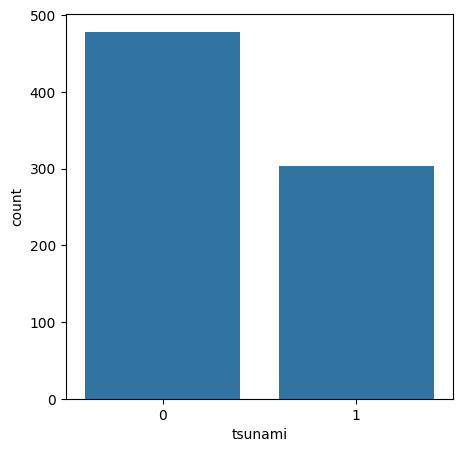

In [23]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='tsunami')

<Axes: xlabel='tsunami', ylabel='count'>

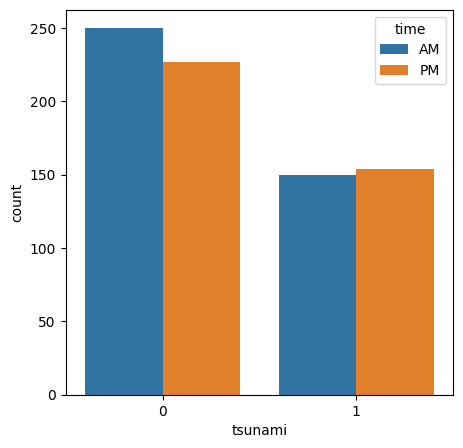

In [24]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='tsunami', hue='time')

In [25]:
df.drop(labels='time', axis=1, inplace=True)

<ipython-input-26-38060375fa9a>:2: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.




<Axes: xlabel='tsunami', ylabel='count'>

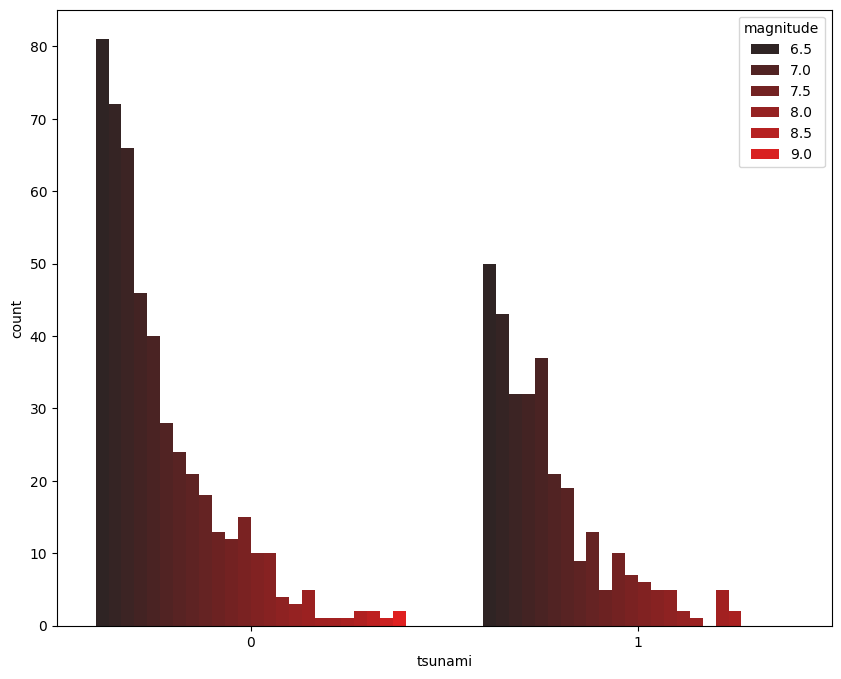

In [26]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='tsunami', hue='magnitude', color='red')

In [27]:
df['magType'].value_counts()

magType
mww    468
mwc    217
mwb     70
mw      16
Mi       4
ms       2
mb       2
md       2
ml       1
Name: count, dtype: int64

In [28]:
df['magType'] = df['magType'].replace({'mw': 'others', 'Mi': 'others', 'ms': 'others', 'mb': 'others', 'md': 'others', 'ml': 'others'})

<Axes: xlabel='tsunami', ylabel='count'>

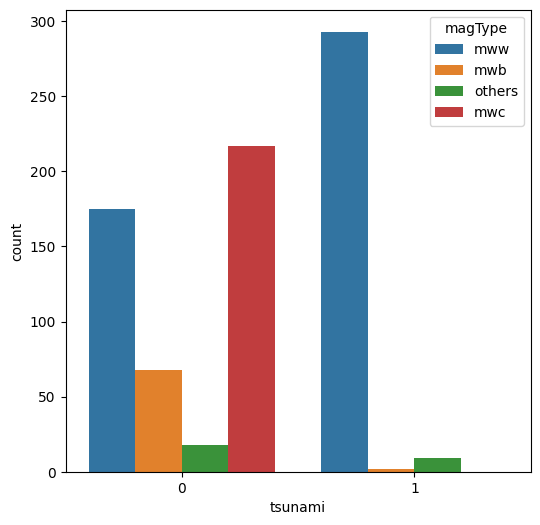

In [29]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='tsunami', hue='magType')

<Axes: xlabel='tsunami', ylabel='count'>

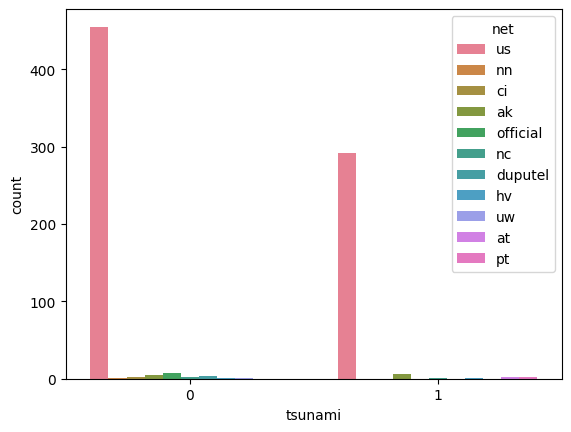

In [30]:
sns.countplot(data=df, x='tsunami', hue='net')

In [31]:
df.drop(labels='net', axis=1, inplace=True)

In [33]:
import geopandas as gpd

# Load the map data
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<ipython-input-33-e88b73f982bd>:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



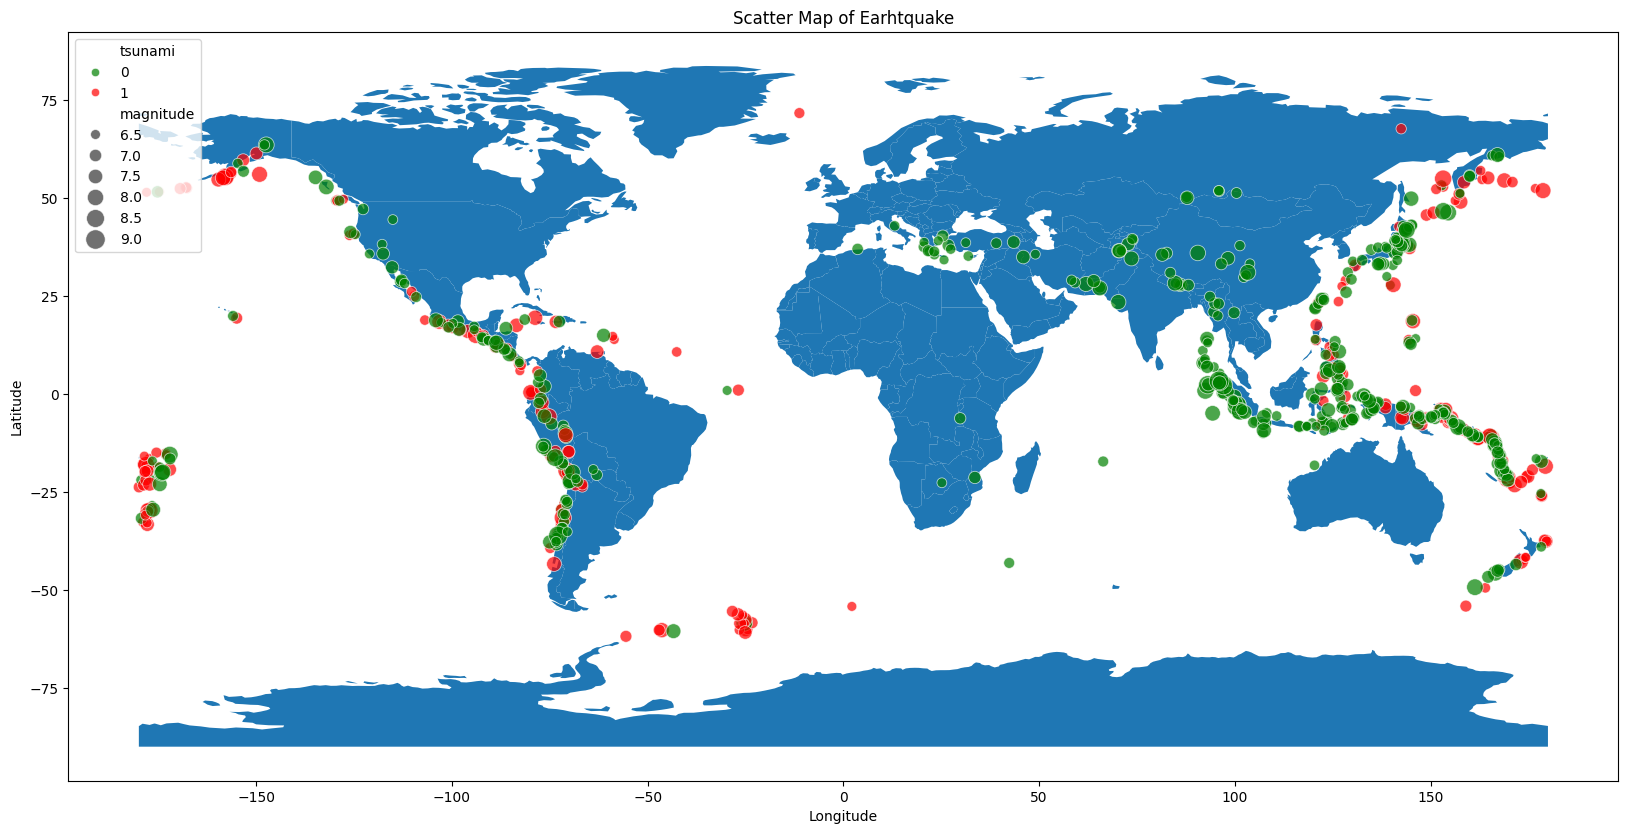

In [34]:
fig, ax = plt.subplots(figsize=(20, 15))
world_map.plot(ax=ax)

sns.scatterplot(data=df, x='longitude', y='latitude', ax=ax, size='magnitude', sizes=(50, 200), alpha=0.7, hue='tsunami', palette={0: 'green', 1: 'red'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Scatter Map of Earhtquake')

plt.legend(loc='upper left')

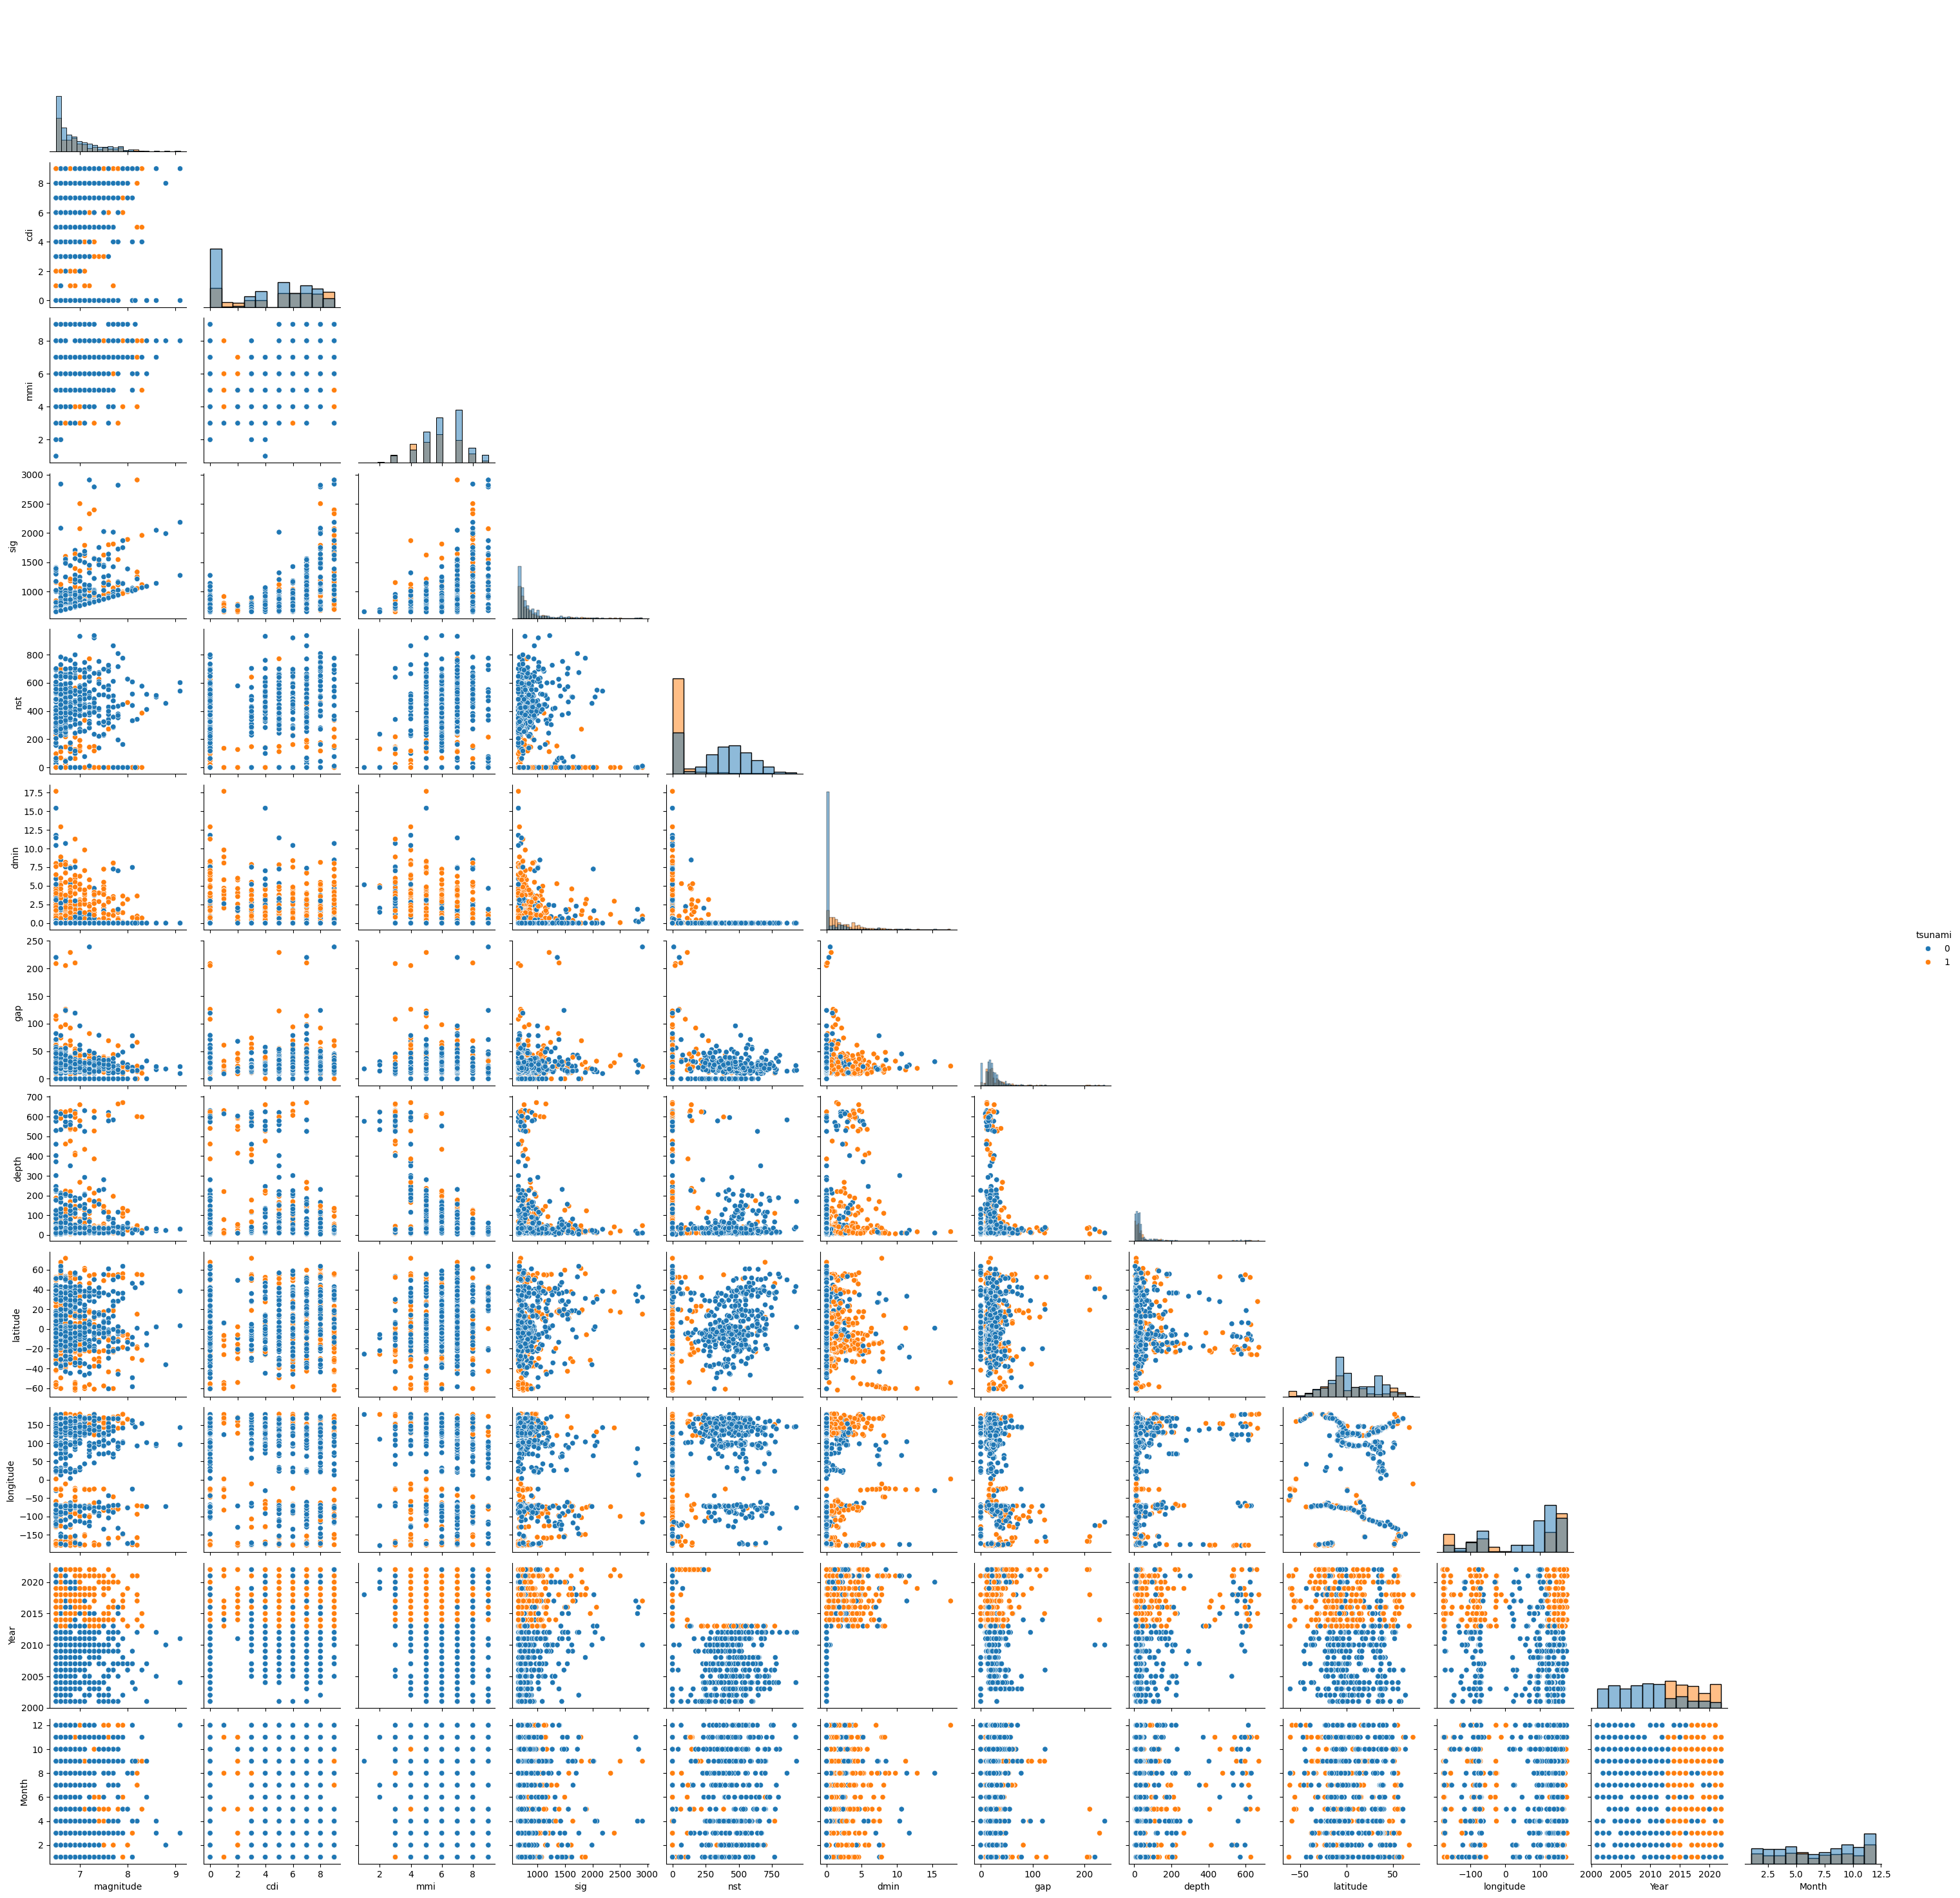

In [35]:
sns.pairplot(df, corner=True, diag_kind='hist', hue='tsunami')

In [36]:
df.head()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,magType,depth,latitude,longitude,country,Year,Month,Time
0,7.0,8,7,1,768,117,0.509,17.0,mww,14.000,-9.7963,159.596,Solomon Islands,2022,11,02:03:00
1,6.9,4,4,0,735,99,2.229,34.0,mww,25.000,-4.9559,100.738,NaN,2022,11,13:37:00
2,7.0,3,3,1,755,147,3.125,18.0,mww,579.000,-20.0508,-178.346,Fiji,2022,11,07:09:00
3,7.3,5,5,1,833,149,1.865,21.0,mww,37.000,-19.2918,-172.129,NaN,2022,11,10:48:00
4,6.6,0,2,1,670,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,2022,11,10:14:00


In [37]:
df.drop(labels=['dmin'], axis=1, inplace=True)

In [38]:
num = list(df.select_dtypes(exclude='O').columns)
num.remove('tsunami')
cat = list(df.select_dtypes(include='O').columns)

In [39]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Drop non-numeric columns or transform them into numeric format
df_numeric = df.drop(non_numeric_cols, axis=1)  # Drop non-numeric columns

# Train Models

In [40]:
# Separate features and target variable
X = df_numeric.drop('tsunami', axis=1)
y = df_numeric['tsunami']

In [41]:
# Split data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Print the shapes of the training and testing sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(547, 11)
(547,)
(235, 11)
(235,)


In [42]:

# Train the Support Vector Machine model on the training data
svr_model = SVR()
svr_model.fit(X_train, y_train)


SVR()

In [44]:
DecisionTreeRegressor_model = DecisionTreeRegressor()
DecisionTreeRegressor_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
MLPRegressor_model = MLPRegressor(random_state=42)
MLPRegressor_model.fit(X_train, y_train)

MLPRegressor(random_state=42)

In [47]:
LinearRegression_model = LinearRegression()
LinearRegression_model.fit(X_train, y_train)

LinearRegression()

# Test Models and Evaluation

In [48]:
# Make predictions on the testing set using the trained Support Vector MAchine model
svr_preds = svr_model.predict(X_test)

In [49]:
# Make predictions on the testing set using the trained Decision Tree model
DecisionTreeRegressor_preds = DecisionTreeRegressor_model.predict(X_test)

In [50]:
# Make predictions on the testing set using the trained Multilayer Perceptron model
MLPRegressor_preds = MLPRegressor_model.predict(X_test)

In [51]:
# Make predictions on the testing set using the trained Linear Regression model
LinearRegression_preds = LinearRegression_model.predict(X_test)

In [55]:
y_train = y_train[pd.to_numeric(y_train, errors='coerce').notnull()]

In [62]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Train Linear Regression
linreg = LinearRegression()
linreg.fit(x_train, y_train)


# Train MLP
mlp = MLPClassifier(random_state=42)
mlp.fit(x_train, y_train)



# Train Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train, y_train)


# Train SVR
svr = SVR()
svr.fit(x_train, y_train)




SVR()

In [64]:
print("Length of y_test:", len(y_test))
print("Length of svr_preds:", len(svr_preds))


Length of y_test: 235
Length of svr_preds: 235


In [78]:
#accuracy_svr = accuracy_score(y_test, svr_preds)
#conf_matrix_svr = confusion_matrix(y_test, svr_preds)
#classification_rep_svr = classification_report(y_test, svr_preds)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_svr = mean_squared_error(y_test, svr_preds)
rmse_svr = mean_squared_error(y_test, svr_preds, squared=False)
mae_svr = mean_absolute_error(y_test, svr_preds)
r2_svr = r2_score(y_test, svr_preds)

print("Mean Squared Error (MSE):", mse_svr)
print("Root Mean Squared Error (RMSE):", rmse_svr)
print("Mean Absolute Error (MAE):", mae_svr)
print("R-squared (R2) Score:", r2_svr)

Mean Squared Error (MSE): 0.18455884848646906
Root Mean Squared Error (RMSE): 0.42960312904641307
Mean Absolute Error (MAE): 0.2879077232040798
R-squared (R2) Score: 0.24085636766980112


In [97]:
from sklearn.neural_network import MLPRegressor

# Create an instance of the MLPRegressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

# Train the model on your training data
mlp_model.fit(X_train, y_train)

# Make predictions using the trained model
mlp_preds = mlp_model.predict(X_test)

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate predictions on the training data
train_preds = mlp_model.predict(X_train)

# Calculate predictions on the test data
test_preds = mlp_model.predict(X_test)

# Calculate evaluation metrics
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print('Mean Squared Error (MSE) - Train:', train_mse)
print('Mean Squared Error (MSE) - Test:', test_mse)
print('Root Mean Squared Error (RMSE) - Train:', train_rmse)
print('Root Mean Squared Error (RMSE) - Test:', test_rmse)
print('Mean Absolute Error (MAE) - Train:', train_mae)
print('Mean Absolute Error (MAE) - Test:', test_mae)

Mean Squared Error (MSE) - Train: 0.6036372922211141
Mean Squared Error (MSE) - Test: 1.0380291974219238
Root Mean Squared Error (RMSE) - Train: 0.7769409837440127
Root Mean Squared Error (RMSE) - Test: 1.018837179053613
Mean Absolute Error (MAE) - Train: 0.5671473468039905
Mean Absolute Error (MAE) - Test: 0.691620234804686


In [102]:
y_train.value_counts()

tsunami
1    341
0    341
Name: count, dtype: int64

In [103]:
# Handle imbalance data
over_sampling = RandomOverSampler(random_state=10)
X_train, y_train = over_sampling.fit_resample(X_train, y_train)

In [80]:
y_train.value_counts()

tsunami
1    341
0    341
Name: count, dtype: int64

In [81]:
# Pipeline

def modelling(X, y, algo):

    transform = ColumnTransformer([
        ('numerical', MinMaxScaler(), num),
        ('categoric', OneHotEncoder(), cat)
    ])

    pipeline = Pipeline([
        ('transform', transform),
        ('algo', algo)
    ])

    pipeline.fit(X, y)

    return pipeline

In [ ]:
linreg = modelling(X=X_train, y=y_train, algo=LinearRegression())

In [77]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder on the training data
le.fit(X_train)

# Transform both the training and test data
X_train_encoded = le.transform(X_train)
X_test_encoded = le.transform(X_test)

# Create a new pipeline with the encoded data
linreg = Pipeline(steps=[('preprocessing', le),
                          ('classifier', LinearRegression())])

# Fit the model on the encoded training data
linreg.fit(X_train_encoded, y_train)

# Evaluate the model on the encoded test data
print('Accuracy Data Train : ', linreg.score(X_train_encoded, y_train))
print('Accuracy Data Test : ', linreg.score(X_test_encoded, y_test))

ValueError: y should be a 1d array, got an array of shape (682, 11) instead.

In [83]:
# Count missing values
df.isna().sum()

magnitude      0
cdi            0
mmi            0
tsunami        0
sig            0
nst            0
gap            0
magType        0
depth          0
latitude       0
longitude      0
country      298
Year           0
Month          0
Time           0
dtype: int64

In [84]:
# Count duplicates
df.duplicated().sum()

0

In [85]:
# Summary statistics of the data
df.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,gap,depth,latitude,longitude,Year,Month
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,0.388747,870.108696,230.250639,25.038990,75.883199,3.538100,52.609199,2012.280051,6.563939
std,0.445514,3.169939,1.462724,0.487778,322.465367,250.188177,24.225067,137.277078,27.303429,117.898886,6.099439,3.507866
min,6.500000,0.000000,1.000000,0.000000,650.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000,2001.000000,1.000000
25%,6.600000,0.000000,5.000000,0.000000,691.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050,2007.000000,3.250000
50%,6.800000,5.000000,6.000000,0.000000,754.000000,140.000000,20.000000,26.295000,-2.572500,109.426000,2013.000000,7.000000
75%,7.100000,7.000000,7.000000,1.000000,909.750000,445.000000,30.000000,49.750000,24.654500,148.941000,2017.000000,10.000000
max,9.100000,9.000000,9.000000,1.000000,2910.000000,934.000000,239.000000,670.810000,71.631200,179.662000,2022.000000,12.000000


In [86]:
# visualize the strength of relationships between features
corr = df.corr()

plt.figure(figsize=(40, 20)) # correlation matrix size

heatmap = sns.heatmap(corr,
                      vmin=-1, vmax=1,
                      linewidths=4,        # Adjust line width between squares
                      cmap="Pastel2",      # Choose a colormap for visualization
                      annot=True,          # Display correlation values on the correlation matrix
                      annot_kws={"color": "black",        # Annotations color
                                 "size": 12,              # Annotations size
                                 "fontweight": "bold"})   # Annotations style

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  # Colorbar label size

# Axes' labels and title size
plt.xlabel("X-axis features", fontsize=25)
plt.ylabel("Y-axis features", fontsize=25)
plt.title("Correlation Heatmap", fontsize=30)

# Axes tick labels' size
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

# Display the correlation matrix
plt.show()

ValueError: could not convert string to float: 'mww'

In [87]:
# Visualize distribution of correlation coefficients
corr.hist(figsize=(35,15))
# Display the histogram
plt.show()

NameError: name 'corr' is not defined

In [88]:
#Evaluation Metrics Function
def evaluate_model(name, y_true, y_pred):

    print(f"{name} Model:")

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error: {mae:.5f}")

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Mean Squared Error: {mse:.5f}")

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error: {rmse:.5f}")

    # Calculate R-squared (R²)
    r2 = r2_score(y_true, y_pred)
    print(f"R^2 Score: {r2:.5f}")

    print("_________________________________________________")

In [89]:
# Print model evaluation results
evaluate_model("SVR", y_test, svr_preds)
evaluate_model("Decision Tree", y_test, dt_preds)
evaluate_model("MLP", y_test, mlp_preds)
evaluate_model("Linear Regression", y_test, lr_preds)

SVR Model:
Mean Absolute Error: 0.28791
Mean Squared Error: 0.18456
Root Mean Squared Error: 0.42960
R^2 Score: 0.24086
_________________________________________________


NameError: name 'dt_preds' is not defined

# Actual VS Predicted Visualisation

In [ ]:
# Compare the actual values with the SVR model's predicted values
results_svr = pd.DataFrame({'Actual': y_test, 'SVR Predicted': svr_preds})
print("SVR Model:")
print(results_svr)

In [ ]:
# Compare the actual values with the Decission Tree model's predicted values
results_dt = pd.DataFrame({'Actual': y_test, 'Decision Tree Predicted': dt_preds})
print("Decision Tree Model:")
print(results_dt)

In [ ]:
# Compare the actual values with the MLP model's predicted values
results_mlp = pd.DataFrame({'Actual': y_test, 'MLP Predicted': mlp_preds})
print("MLP Model:")
print(results_mlp)

In [ ]:
# Compare the actual values with the Linear Regression model's predicted values
results_lr = pd.DataFrame({'Actual': y_test, 'Linear Regression Predicted': lr_preds})
print("Linear Regression Model:")
print(results_lr)

In [ ]:
# Visualizing Linear Regression Predictions Compared to Real Values
plt.figure(figsize=(20, 5)) # Set figure size
plt.plot(y_test.values, label='Real Value')  # Plot real values from y_test
plt.plot(lr_preds, label='Linear Regression Predicted Value')  # Plot model's predicted values
plt.ylabel('Flood Probability') # Set y-axis label
plt.legend() # Add a legend to the plot
plt.title('Linear Regression: Real vs Predicted Flood Probability') # Plot title
plt.show() # Display the plot

In [ ]:
# Visualizing SVR Predictions Compared to Real Values
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label='Real Value')
plt.plot(svr_preds, label='SVR Predicted Value')
plt.ylabel('Flood Probability')
plt.legend()
plt.title('SVR: Real vs Predicted Flood Probability')
plt.show()

In [ ]:
# Visualizing MLP Predictions Compared to Real Values
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label='Real Value')
plt.plot(mlp_preds, label='MLP Predicted Value')
plt.ylabel('Flood Probability')
plt.legend()
plt.title('MLP: Real vs Predicted Flood Probability')
plt.show()

In [ ]:
# Visualizing Decision Tree Predictions Compared to Real Values
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label='Real Value')
plt.plot(dt_preds, label='Decision Tree Predicted Value')
plt.ylabel('Flood Probability')
plt.legend()
plt.title('Decision Tree: Real vs Predicted Flood Probability')
plt.show()

In [ ]:
# Visualizing all four models Predictions Compared to their Real Values
plt.figure(figsize=(20, 10))

plt.plot(y_test.values, label='Real Value')
plt.plot(svr_preds, label='SVR Predicted Value', linestyle='dashed')
plt.plot(dt_preds, label='Decision Tree Predicted Value', linestyle='dashdot')
plt.plot(mlp_preds, label='MLP Predicted Value', linestyle='dotted')
plt.plot(lr_preds, label='Linear Regression Predicted Value', linestyle='-.')

plt.ylabel('Flood Probability')
plt.legend()
plt.title('Comparison of Actual vs Predicted Flood Probability')
plt.show()

# Implement Average Classifier on best performing models

In [95]:
# Implement an average classifier by calculating the average prediction from the two best performing models
average_prediction = (mlp_preds + lr_preds) / 2

NameError: name 'mlp_preds' is not defined

In [ ]:
# Compare the actual values with the Average Classifier model's predicted values
results_avg = pd.DataFrame({'Actual': y_test, 'Average Predicted': average_prediction})
print("Average Prediction from all Models:")
print(results_avg)

In [ ]:
# Evaluate the performance of the average prediction by comparing it to the actual values
evaluate_model("Average Prediction from all Models:", y_test, average_prediction)

In [ ]:
# Visualizing Average Classifier Predictions Compared to Real Values
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label='Real Value')
plt.plot(average_prediction, label='Ensemble Averaging Value')
plt.ylabel('Flood Probability')
plt.legend()
plt.title('Ensemble Averaging: Real vs Predicted Flood Probability')
plt.show()

# Import and Load models

In [94]:
# Save the trained models using joblib
joblib.dump(svr_model, '/content/Models/svr_model.pkl')
joblib.dump(dt_model, '/content/Models/dt_model.pkl')
joblib.dump(mlp_model, '/content/Models/mlp_model.pkl')
joblib.dump(lr_model, '/content/Models/lr_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Models/svr_model.pkl'

#  Predict using new data

In [90]:
# Load the previously trained models using joblib

svr_model = joblib.load('/content/Models/svr_model.pkl')
dt_model = joblib.load('/content/Models/dt_model.pkl')
mlp_model = joblib.load('/content/Models/mlp_model.pkl')
lr_model = joblib.load('/content/Models/lr_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Models/svr_model.pkl'

In [91]:
# Input sample data for a new prediction
data = {
    'MonsoonIntensity': [3],
    'TopographyDrainage': [8],
    'RiverManagement': [6],
    'Deforestation': [6],
    'Urbanization': [4],
    'ClimateChange': [4],
    'DamsQuality': [6],
    'Siltation': [2],
    'AgriculturalPractices': [3],
    'Encroachments': [2],
    'IneffectiveDisasterPreparedness': [5],
    'DrainageSystems': [10],
    'CoastalVulnerability': [7],
    'Landslides': [4],
    'Watersheds': [2],
    'DeterioratingInfrastructure': [3],
    'PopulationScore': [4],
    'WetlandLoss': [3],
    'InadequatePlanning': [2],
    'PoliticalFactors': [6]
}

In [92]:
# Create a DataFrame from the new data
input_data = pd.DataFrame(data)

In [93]:
# Make predictions using the sample data and the previously trained models
svr_prediction = svr_model.predict(input_data)
dt_prediction = dt_model.predict(input_data)
mlp_prediction = mlp_model.predict(input_data)
lr_prediction = lr_model.predict(input_data)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AgriculturalPractices
- ClimateChange
- CoastalVulnerability
- DamsQuality
- Deforestation
- ...
Feature names seen at fit time, yet now missing:
- Month
- Year
- cdi
- depth
- gap
- ...


In [ ]:
# Print new predictions
print("SVR Prediction:", svr_prediction)
print("Decision Tree Prediction:", dt_prediction)
print("MLP Prediction:", mlp_prediction)
print("Linear Regression Prediction:", lr_prediction)